In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import json
from PIL import Image
import pickle
import time

from sklearn.model_selection import cross_val_score, KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer
from sklearn.preprocessing import normalize

from define_dataset import define_dataset
from define_ext_dataset import define_ext_dataset
from ml_models import build_SVM, build_random_forest

# Import slide targets

In [2]:
comb_tr_set = np.load('./data/comb_tr_set.npy')
comb_val_set = np.load('./data/comb_val_set.npy')
comb_ts_set = np.load('./data/comb_ts_set.npy')
targets_comb_tr = np.load('./data/comb_tr_targets.npy')
targets_comb_val = np.load('./data/comb_val_targets.npy')
targets_comb_ts = np.load('./data/comb_ts_targets.npy')

In [3]:
# Dicts with number of tiles for each slide
tiles_num_dict_path = './data/num_tiles_dict_comb_tr.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_comb_tr = json.load(json_file)
    
tiles_num_dict_path = './data/num_tiles_dict_comb_val.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_comb_val = json.load(json_file)

tiles_num_dict_path = './data/num_tiles_dict_comb_ts.json'
with open(tiles_num_dict_path) as json_file:
    num_tiles_dict_comb_ts = json.load(json_file)

In [4]:
epoch = 20
save_model_path = './ae_models/comb_ae/'
embed_dim = 32

Paths

In [5]:
avg_embed_pth =  os.path.join("./avg_embed", "comb_ae")
if not os.path.exists(avg_embed_pth):
    os.makedirs(avg_embed_pth)

comb_tr_avg_embed_pth = os.path.join(avg_embed_pth, "avg_embed_comb_tr.npy")
comb_val_avg_embed_pth = os.path.join(avg_embed_pth, "avg_embed_comb_val.npy")
comb_ts_avg_embed_pth = os.path.join(avg_embed_pth, "avg_embed_comb_ts.npy")

# Calculate average embedding

For each slide, we calculate the average embedding over all of its tiles

In [6]:
def subdivide_embed_by_slide(embed_tiles, dataset='comb_tr'):
    # Labels are still ordered by slide, ie the first 25000 tiles are from the first slide, tile 25001
    # to 70000 is from the second slide and so on
    
    if dataset=='comb_val':
        num_tiles_dict = num_tiles_dict_comb_val
    elif dataset=='comb_ts':
        num_tiles_dict = num_tiles_dict_comb_ts
    else:
        num_tiles_dict = num_tiles_dict_comb_tr

    all_slides_embed_arr = []

    start = 0
    end = 0
    for slide_name in num_tiles_dict:
        slide_num_tiles = num_tiles_dict[slide_name]
        end += slide_num_tiles
        slide_embed = embed_tiles[start:end]
        start += slide_num_tiles
        all_slides_embed_arr.append(slide_embed)
        
    return all_slides_embed_arr

Combined Training set

In [7]:
embed_path_comb_tr = os.path.join(save_model_path, 'z_ae_test_epoch{}.npy'.format(epoch))
embed_tiles_comb_tr = np.load(embed_path_comb_tr)

In [8]:
# Array containing, for each slide, the array of all the slide tiles embeddings
comb_tr_slides_embed_arr = subdivide_embed_by_slide(embed_tiles_comb_tr, 'comb_tr')

In [9]:
comb_tr_slides_avg_embed = np.zeros((len(comb_tr_set), embed_dim))

for i, slide_embed in enumerate(comb_tr_slides_embed_arr):
    avg_embed = np.average(slide_embed, axis=0)
    comb_tr_slides_avg_embed[i] = avg_embed
    
np.save(comb_tr_avg_embed_pth, comb_tr_slides_avg_embed)

Combined Validation Set

In [10]:
embed_path_comb_val = os.path.join(save_model_path, 'z_ae_internal_test_epoch{}.npy'.format(epoch))
embed_tiles_comb_val = np.load(embed_path_comb_val)

In [11]:
# Array containing, for each slide, the array of all the slide tiles embeddings
comb_val_slides_embed_arr = subdivide_embed_by_slide(embed_tiles_comb_val, 'comb_val')

In [12]:
comb_val_slides_avg_embed = np.zeros((len(comb_val_set), embed_dim))

for i, slide_embed in enumerate(comb_val_slides_embed_arr):
    avg_embed = np.average(slide_embed, axis=0)
    comb_val_slides_avg_embed[i] = avg_embed
    
np.save(comb_val_avg_embed_pth, comb_val_slides_avg_embed)

Combined test set

In [13]:
embed_path_comb_ts = os.path.join(save_model_path, 'z_ae_ext_test_epoch{}.npy'.format(epoch))
embed_tiles_comb_ts = np.load(embed_path_comb_ts)

In [14]:
# Array containing, for each slide, the array of all the slide tiles embeddings
comb_ts_slides_embed_arr = subdivide_embed_by_slide(embed_tiles_comb_ts, 'comb_ts')

In [15]:
comb_ts_slides_avg_embed = np.zeros((len(comb_ts_set), embed_dim))

for i, slide_embed in enumerate(comb_ts_slides_embed_arr):
    avg_embed = np.average(slide_embed, axis=0)
    comb_ts_slides_avg_embed[i] = avg_embed
    
np.save(comb_ts_avg_embed_pth, comb_ts_slides_avg_embed)

 # Visualize average embedding

Tr set

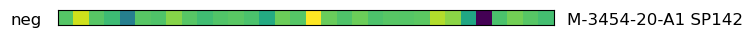

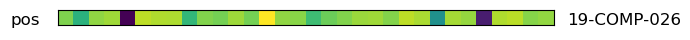

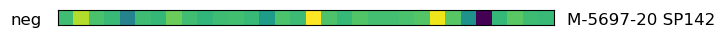

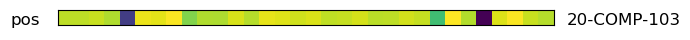

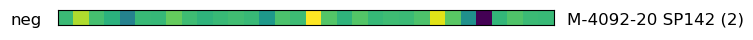

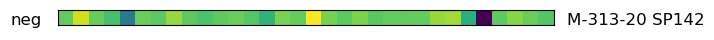

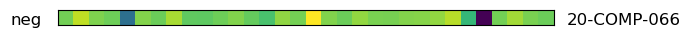

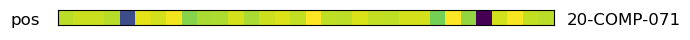

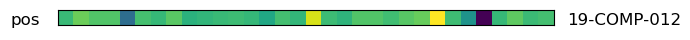

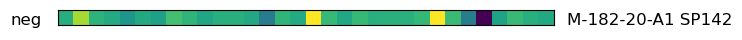

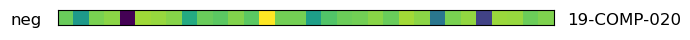

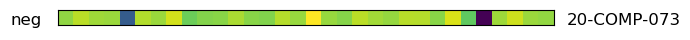

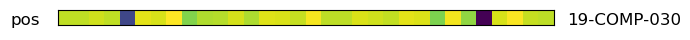

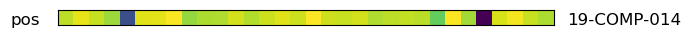

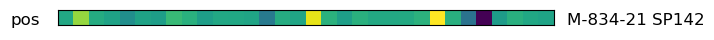

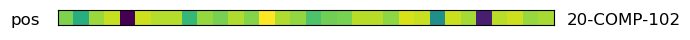

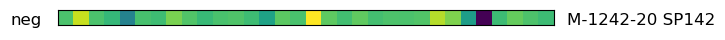

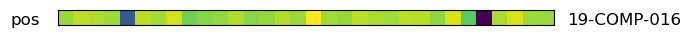

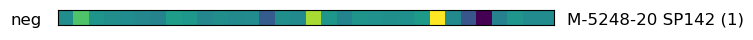

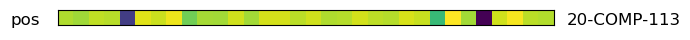

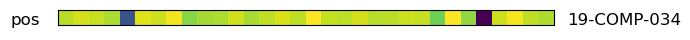

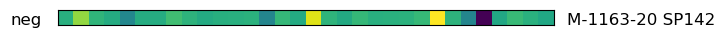

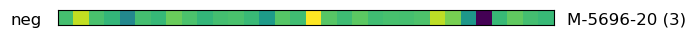

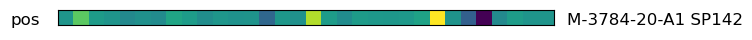

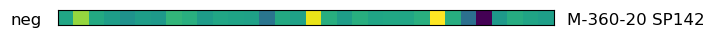

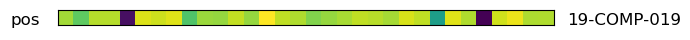

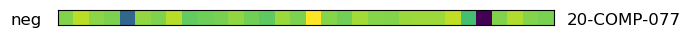

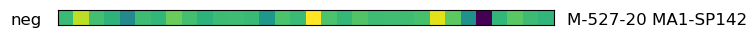

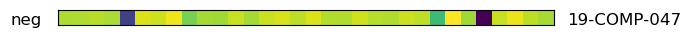

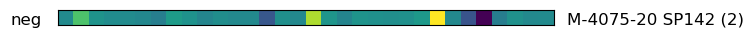

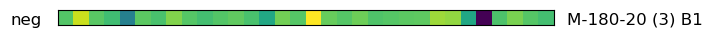

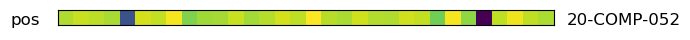

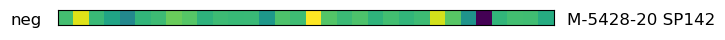

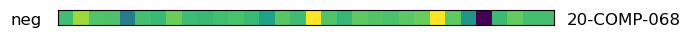

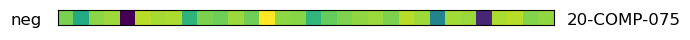

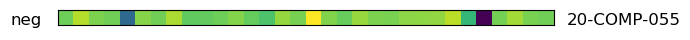

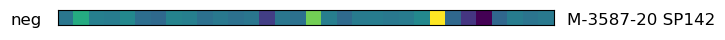

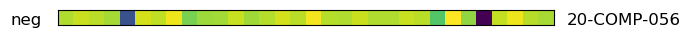

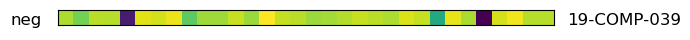

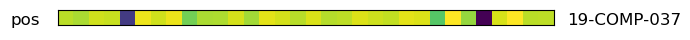

In [16]:
tr_slides_avg_embed = np.load(comb_tr_avg_embed_pth)

for i, slide_name in enumerate(comb_tr_set):
    slide_avg_embed = np.reshape(comb_tr_slides_avg_embed[i], (1,len(comb_tr_slides_avg_embed[i])))
    
    ax = plt.gca()
    plt.imshow(slide_avg_embed)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.gcf().text(0.92, 0.48, slide_name, fontsize=12)
    if targets_comb_tr[i] == 1:
            positivity = 'pos'
    else:
            positivity = 'neg'
    plt.gcf().text(0.05, 0.48, positivity, fontsize=12)
    
    plt.show()

Validation set

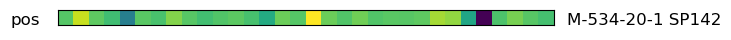

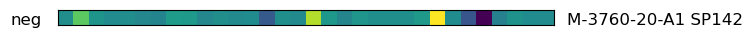

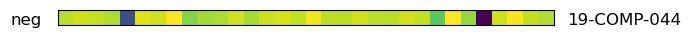

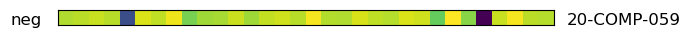

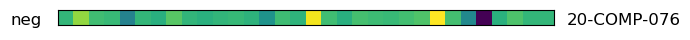

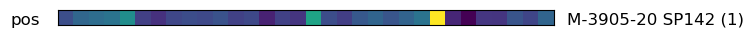

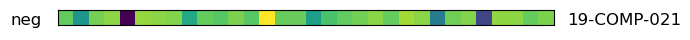

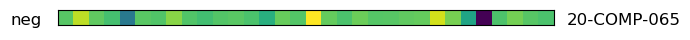

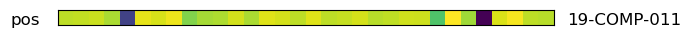

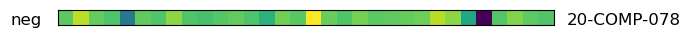

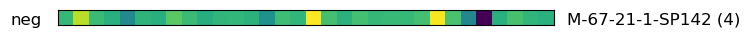

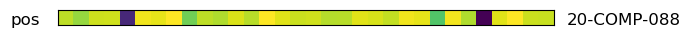

In [17]:
comb_val_slides_avg_embed = np.load(comb_val_avg_embed_pth)

for i, slide_name in enumerate(comb_val_set):
    slide_avg_embed = np.reshape(comb_val_slides_avg_embed[i], (1,len(comb_val_slides_avg_embed[i])))
    
    ax = plt.gca()
    plt.imshow(slide_avg_embed)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.gcf().text(0.92, 0.48, slide_name, fontsize=12)
    if targets_comb_val[i] == 1:
            positivity = 'pos'
    else:
            positivity = 'neg'
    plt.gcf().text(0.05, 0.48, positivity, fontsize=12)
    
    plt.show()

Combined Test set

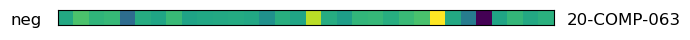

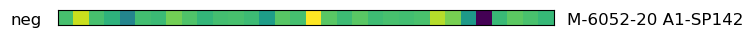

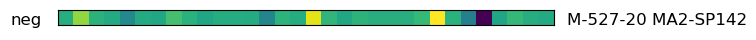

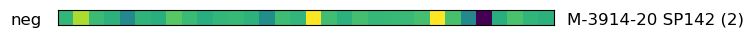

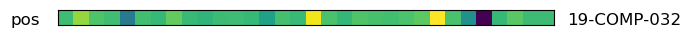

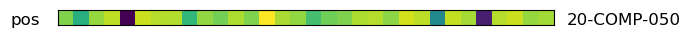

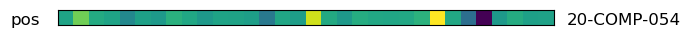

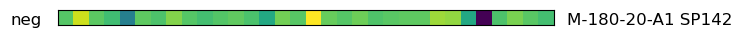

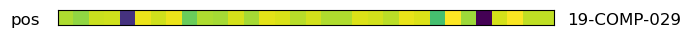

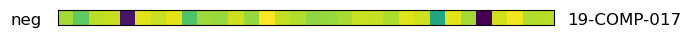

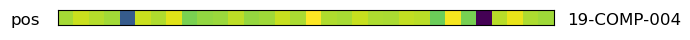

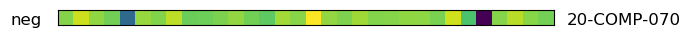

In [18]:
comb_ts_slides_avg_embed = np.load(comb_ts_avg_embed_pth)

for i, slide_name in enumerate(comb_ts_set):
    slide_avg_embed = np.reshape(comb_ts_slides_avg_embed[i], (1,len(comb_ts_slides_avg_embed[i])))
    
    ax = plt.gca()
    plt.imshow(slide_avg_embed)
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.gcf().text(0.92, 0.48, slide_name, fontsize=12)
    if targets_comb_ts[i] == 1:
            positivity = 'pos'
    else:
            positivity = 'neg'
    plt.gcf().text(0.05, 0.48, positivity, fontsize=12)
    
    plt.show()

# Classification

Load inputs

In [19]:
comb_tr_slides_avg_embed = np.load(comb_tr_avg_embed_pth)
comb_val_slides_avg_embed = np.load(comb_val_avg_embed_pth)
comb_ts_slides_avg_embed = np.load(comb_ts_avg_embed_pth)

Train models

In [21]:
# SVM
print('--- SVM ---')
print('Training:')
best_score_svm, best_svm = build_SVM(X=comb_tr_slides_avg_embed, y=targets_comb_tr)
print('Validation:')
pred = best_svm.predict(comb_val_slides_avg_embed)
acc_svm = accuracy_score(y_true=targets_comb_val, y_pred=pred)
f1_svm = f1_score(y_true=targets_comb_val, y_pred=pred)
f1_weight_svm = f1_score(y_true=targets_comb_val, y_pred=pred, average="weighted")

print('acc_score_svm:', acc_svm)
print('f1_score_svm:', f1_svm)
print('f1_weight_score_svm:', f1_weight_svm)
print('\n')

# Random forest
print('--- RANDOM FOREST ---')
print('Training:')
best_score_rf, best_rf = build_random_forest(X=comb_tr_slides_avg_embed, y=targets_comb_tr)
print('Validation:')
pred = best_rf.predict(comb_val_slides_avg_embed)
acc_rf = accuracy_score(y_true=targets_comb_val, y_pred=pred)
f1_rf = f1_score(y_true=targets_comb_val, y_pred=pred)
f1_weight_rf = f1_score(y_true=targets_comb_val, y_pred=pred, average="weighted")

print('acc_score_rf:', acc_rf)
print('f1_score_rf:', f1_rf)
print('f1_weight_score_rf:', f1_weight_rf)

# Save models
models_pth = './classification/class_comb_ae_avg_emb/'
if not os.path.exists(models_pth):
    os.makedirs(models_pth)
svm_pth = os.path.join(models_pth, 'svm')
rf_pth = os.path.join(models_pth, 'rf')

pickle.dump(best_svm, open(svm_pth, 'wb'))
pickle.dump(best_rf, open(rf_pth, 'wb'))

print('\n')

--- SVM ---
Training:
SVM - Best parameters set found:
{'C': 300, 'gamma': 'scale', 'kernel': 'poly'}
SVM - Best accuracy score found:
0.8472222222222222
Validation:
acc_score_svm: 0.6666666666666666
f1_score_svm: 0.5
f1_weight_score_svm: 0.6666666666666666


--- RANDOM FOREST ---
Training:
RF - Best parameters set found:
{'bootstrap': True, 'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'n_estimators': 64}
RF - Best accuraccy score found:
0.798611111111111
Validation:
acc_score_rf: 0.6666666666666666
f1_score_rf: 0.5
f1_weight_score_rf: 0.6666666666666666




In [22]:
print('TEST\n')



svm_pth = './classification/class_comb_ae_avg_emb/svm'
rf_pth = './classification/class_comb_ae_avg_emb/rf'


# SVM
print('--- SVM ---')
trained_svm = pickle.load(open(svm_pth, 'rb'))
pred = trained_svm.predict(comb_ts_slides_avg_embed)
acc_svm = accuracy_score(y_true=targets_comb_ts, y_pred=pred)
f1_svm = f1_score(y_true=targets_comb_ts, y_pred=pred)
f1_weight_svm = f1_score(y_true=targets_comb_ts, y_pred=pred, average="weighted")

print('acc_score_svm:', acc_svm)
print('f1_score_svm:', f1_svm)
print('f1_weight_score_svm:', f1_weight_svm)
print(pred)
print(targets_comb_ts)
print('\n')

# Random forest
print('--- RANDOM FOREST ---')
trained_rf = pickle.load(open(rf_pth, 'rb'))
pred = trained_rf.predict(comb_ts_slides_avg_embed)
acc_rf = accuracy_score(y_true=targets_comb_ts, y_pred=pred)
f1_rf = f1_score(y_true=targets_comb_ts, y_pred=pred)
f1_weight_rf = f1_score(y_true=targets_comb_ts, y_pred=pred, average="weighted")

print('acc_score_rf:', acc_rf)
print('f1_score_rf:', f1_rf)
print('f1_weight_score_rf:', f1_weight_rf)
print(pred)
print(targets_comb_ts)
print('\n')

TEST

--- SVM ---
acc_score_svm: 0.6666666666666666
f1_score_svm: 0.6
f1_weight_score_svm: 0.6666666666666666
[1 0 0 0 1 1 0 0 1 1 0 0]
[0 0 0 0 1 1 1 0 1 0 1 0]


--- RANDOM FOREST ---
acc_score_rf: 0.75
f1_score_rf: 0.6666666666666665
f1_weight_score_rf: 0.7444444444444444
[0 0 0 0 0 1 0 0 1 1 1 0]
[0 0 0 0 1 1 1 0 1 0 1 0]


